In [1]:
import sys

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from bindsnet.environment import GymEnvironment
from bindsnet.learning.reward import AbstractReward, MovingAvgRPE
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_weights
from interactive_env.agents import CartPoleObserverAgent, ExpertAgent
from interactive_env.pipelines import ToMPipeline

In [3]:
%matplotlib inline

In [4]:
def _compute_spikes(
    datum: torch.Tensor,
    time: int,
    low: float,
    high: float,
    device: str
) -> torch.Tensor:
    times = torch.linspace(low, high, time, device=device)
    spike_times = torch.argmin(torch.abs(datum - times))
    spikes = (np.array(spike_times.to('cpu')).astype(int) ==
              range(0, time)).astype(int)
    reverse_spikes = np.flip(spikes).copy()
    return torch.stack([
        torch.from_numpy(spikes).to(device),
        torch.from_numpy(reverse_spikes).to(device)
    ]).byte()

In [5]:
def cartpole_observation_encoder(
        datum: torch.Tensor,
        time: int,
        **kwargs,
) -> dict:
    """
    Encode observation vector (Only uses data related to angle). It encodes
    a value and its complement in time. So there are two neurons per value.

    Parameters
    ----------
    datum : torch.Tensor
        Observation tensor.
    time : int
        Length of spike train per observation.

    Keyword Arguments
    -----------------

    Returns
    -------
    dict
        The tensor of encoded data per input population.

    """
    device = "cpu" if datum.get_device() < 0 else 'cuda'
    datum = datum.squeeze()
    angle, velocity = datum[2:4]
    min_angle, max_angle = -0.418, 0.418
    min_velocity, max_velocity = -2, 2

    angle_spikes = _compute_spikes(angle, time, min_angle, max_angle, device)
    velocity_spikes = _compute_spikes(velocity, time, min_velocity,
                                      max_velocity, device)

    spikes = torch.stack([angle_spikes, velocity_spikes]).T

    return {"S2": spikes.unsqueeze(1).byte().to(device)}

In [6]:
def _noise_policy(episode, num_episodes, **kwargs):
    return (1 - episode / num_episodes) ** 2

In [7]:
class CartPoleReward(AbstractReward):
    """
    Computes the error based on whether the episode is done or not. The reward
    amount decreases as the agent observes more good episodes.

    Parameters
    ----------

    Keyword Arguments
    -----------------

    """

    def __init__(self, **kwargs):
        self.alpha = 1.0  # reward multiplier
        self.accumulated_rewards = []  # holder of observation evaluations

    def compute(self, **kwargs):
        """
        Compute the reward.

        Keyword Arguments
        -----------------
        reward : float
            The reward value returned from the environment

        """
        reward = kwargs["reward"]
        return reward * self.alpha if reward > 0 else -self.alpha

    def update(self, **kwargs):
        """
        Update internal attributes.

        Keyword Arguments
        -----------------
        accumulated_reward : float
            The value of accumulated reward in the episode.

        """
        accumulated_reward = kwargs.get("accumulated_reward")
        self.accumulated_rewards.append(accumulated_reward)
        if np.mean(self.accumulated_rewards[-10:]) >= 195:
            self.alpha *= 0.1

In [8]:
# Define the environment
environment = GymEnvironment('CartPole-v0')

C:\Users\yunes\anaconda3\envs\rl_torch\Lib\site-packages\gymnasium\envs\registration.py:523: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [9]:
# Define observer agent
observer = CartPoleObserverAgent(environment, dt=1.0, method='first_spike',
                                 reward_fn=CartPoleReward)

In [10]:
# Define expert agent acting on pretrained weights (weight is multiplied by
# observation vector)
expert = ExpertAgent(environment, method='from_weight',
                     noise_policy=_noise_policy)

In [11]:
# Define the pipeline by which the agents interact
pipeline = ToMPipeline(
    observer_agent=observer,
    expert_agent=expert,
    encoding=cartpole_observation_encoder,
    time=15,
    num_episodes=200,
    representation_time=7,
    log_writer = True,
)

In [12]:
w1 = pipeline.network.connections[("S2", "PM")].w
print(w1)

Parameter containing:
tensor([[ 0.0154, -0.0029],
        [-0.0218,  0.0057],
        [-0.0108, -0.0140],
        [ 0.0040,  0.0084]])


In [71]:
w = torch.load('./experts/hill_climbing.pt')
w

tensor([[1.8765, 2.1951],
        [1.3533, 2.5004],
        [2.3640, 3.0501],
        [1.1404, 2.1906]])

In [13]:
pipeline.observe_learn(weight='./experts/hill_climbing.pt',
                              test_interval=10, num_tests=5)
print("Observation Finished")

Episode: 0 - accumulated reward: 13.00
Episode: 1 - accumulated reward: 24.00
Episode: 2 - accumulated reward: 79.00
Episode: 3 - accumulated reward: 15.00
Episode: 4 - accumulated reward: 19.00
Episode: 5 - accumulated reward: 18.00
Episode: 6 - accumulated reward: 19.00
Episode: 7 - accumulated reward: 31.00
Episode: 8 - accumulated reward: 45.00
Episode: 9 - accumulated reward: 21.00
Test - accumulated reward: 15.0
Test - accumulated reward: 11.0
Test - accumulated reward: 16.0
Test - accumulated reward: 25.0
Test - accumulated reward: 16.0
Episode: 10 - accumulated reward: 13.00
Episode: 11 - accumulated reward: 16.00
Episode: 12 - accumulated reward: 32.00
Episode: 13 - accumulated reward: 105.00
Episode: 14 - accumulated reward: 47.00
Episode: 15 - accumulated reward: 62.00
Episode: 16 - accumulated reward: 20.00
Episode: 17 - accumulated reward: 39.00
Episode: 18 - accumulated reward: 20.00
Episode: 19 - accumulated reward: 18.00
Test - accumulated reward: 12.0
Test - accumulate

Episode: 146 - accumulated reward: 200.00
Episode: 147 - accumulated reward: 182.00
Episode: 148 - accumulated reward: 200.00
Episode: 149 - accumulated reward: 200.00
Test - accumulated reward: 200.0
Test - accumulated reward: 200.0
Test - accumulated reward: 200.0
Test - accumulated reward: 200.0
Test - accumulated reward: 200.0
Episode: 150 - accumulated reward: 200.00
Episode: 151 - accumulated reward: 200.00
Episode: 152 - accumulated reward: 200.00
Episode: 153 - accumulated reward: 200.00
Episode: 154 - accumulated reward: 200.00
Episode: 155 - accumulated reward: 200.00
Episode: 156 - accumulated reward: 200.00
Episode: 157 - accumulated reward: 200.00
Episode: 158 - accumulated reward: 200.00
Episode: 159 - accumulated reward: 200.00
Test - accumulated reward: 200.0
Test - accumulated reward: 200.0
Test - accumulated reward: 200.0
Test - accumulated reward: 200.0
Test - accumulated reward: 200.0
Episode: 160 - accumulated reward: 200.00
Episode: 161 - accumulated reward: 200.0

In [16]:
import os

In [18]:
os.mkdir("./plots")

In [63]:
dir(pipeline.network.connections[("S2", "PM")])

['T_destination',
 '__abstractmethods__',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modul

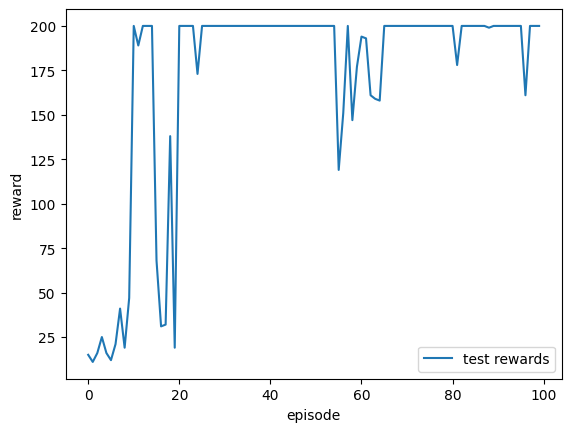

In [20]:
plt.plot(pipeline.test_rewards, label='test rewards')
plt.xlabel("episode")
plt.ylabel("reward")
plt.legend()
plt.savefig(f"./plots/test_rewards_{7_11_180}.png")

Parameter containing:
tensor([[ 0.9988, -1.0000],
        [ 1.0000, -1.0000],
        [-1.0000,  0.9995],
        [-1.0000,  1.0000]])


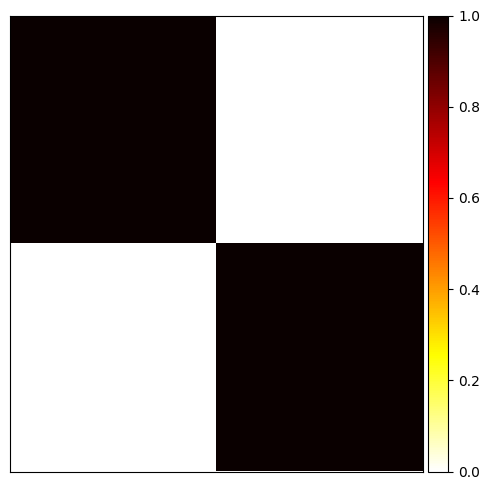

In [21]:
w1 = pipeline.network.connections[("S2", "PM")].w
plot_weights(w1)
print(w1)

In [28]:
pipeline.episode = 194

In [31]:
pipeline._test(False, test_interval=5, num_tests=5)

Test - accumulated reward: 200.0
Test - accumulated reward: 200.0
Test - accumulated reward: 200.0
Test - accumulated reward: 200.0
Test - accumulated reward: 200.0


In [70]:
np.mean(pipeline.test_rewards[:100])

170.7